## Import stuff

In [93]:
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import shutil
import random
from PIL import Image
import logging
import time
import sklearn.metrics as metrics


## Load training data from csv


In [94]:
val_data = pd.read_csv("val_distances.csv",index_col=0)
val_labels = pd.read_csv("val_labels.txt", header=None)

for extractor in ["xl","resnet","clip","vit","swin"]:
    val_data[extractor] = val_data["anchor_left_distance_"+extractor]-val_data["anchor_right_distance_"+extractor]
    val_data.drop("anchor_left_distance_"+extractor, axis=1, inplace=True)
    val_data.drop("anchor_right_distance_"+extractor, axis=1, inplace=True)


X_val = np.array(val_data.iloc[:, :].values,  dtype=float)
Y_val = np.array(val_labels.iloc[:, :].values,  dtype=float).reshape(-1)

print("X shape: ", X_val.shape)
print("Y shape: ", Y_val.shape)

val_data

X shape:  (7471, 5)
Y shape:  (7471,)


,xl,resnet,clip,vit,swin
0,-0.297992,-0.462003,-0.497801,-0.304850,-0.556594
1,-0.171737,-0.072772,-0.203814,-0.099252,0.020896
2,0.173895,0.209145,-0.078201,-0.049250,0.043718
3,-0.675008,-0.787609,-1.093797,-1.215614,-0.732954
4,0.573244,0.468123,0.475904,-0.040818,0.330896
...,...,...,...,...,...
7466,-0.331405,-0.236907,-0.830325,-0.802837,-0.522852
7467,0.053754,0.338329,0.027265,0.135439,-0.199139
7468,-0.153118,-0.625337,0.112721,-0.260577,-0.326937
7469,0.373239,0.512580,0.491642,0.311056,0.357579


# weighted ensemble
the weights would be kinda hard to estimate in practice, it would take a few server submissions. I just made the worse 2 models less important

In [95]:
pred = []
for row in X_val:
    score_left = 0.5*row[0]+row[1]+row[2]+0.5*row[3]
    pred.append(score_left>0)

pred = np.array(pred)
accuracy = metrics.accuracy_score(Y_val, pred)
accuracy

0.7849016195957703

# Majority vote
performs worse

In [96]:
# pred = []
# for row in X_val:
#     score_left = 0
#     score_left += row[0]>0
#     score_left += row[1]>0
#     score_left += row[2]>0
#     score_left += row[3]>0
#     score_left += row[4]>0
#     pred.append(0 if score_left>2 else 1)

# pred = np.array(pred)
# accuracy = metrics.accuracy_score(Y_val, pred<0.5)
# accuracy

# Miss-classified triplets

In [97]:
# This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 3, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

val_triplets = np.loadtxt('./val_triplets_split.txt', dtype=str,delimiter = ' ')

In [98]:
id=85

id: 86 model predicted: 1.14968835 label: left


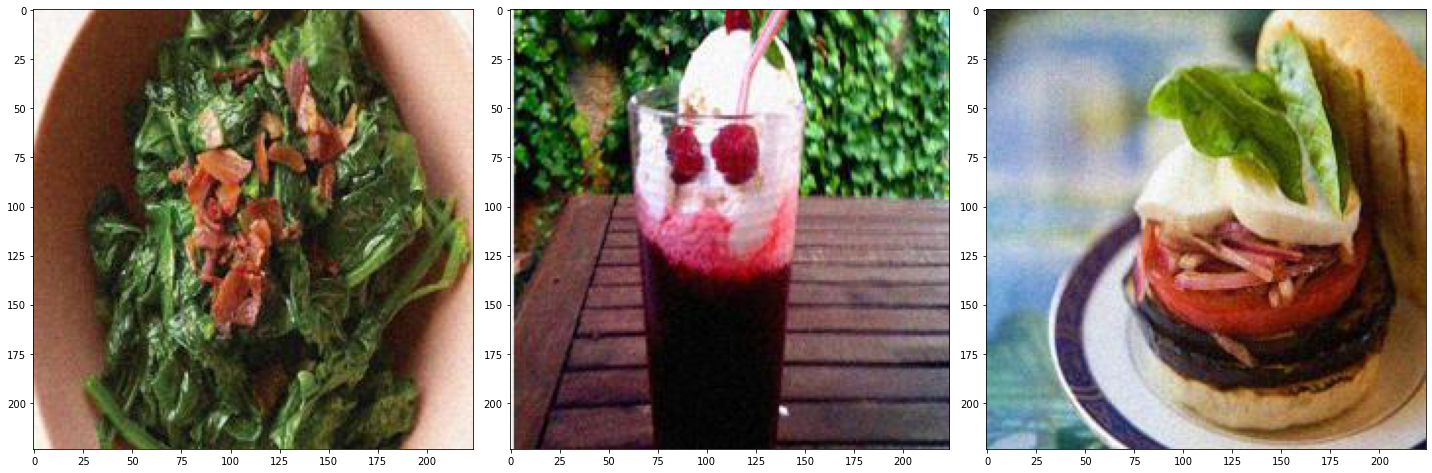

In [99]:
while True:
    #find next triplet that was missclassified, and plot it
    id+=1
    if pred[id] != Y_val[id]:
        anchor = Image.open('food_224/' + val_triplets[id][0] + '.jpg')
        left = Image.open('food_224/' + val_triplets[id][1] + '.jpg')
        right = Image.open('food_224/' + val_triplets[id][2] + '.jpg')
        row = X_val[id]
        score_left = 0.5*row[0]+row[1]+row[2]+0.5*row[3]
        print("id: " + str(id) + " model predicted: " + str(score_left) + " label: " + ("left" if Y_val[id]==0 else "right"))
        plotImages([anchor, left, right])
        break
        
